<a href="https://colab.research.google.com/github/mateollorente/Producto/blob/master/BuenVector2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from google.colab import userdata
import os, json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models


In [2]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git
%cd BeatAI

Cloning into 'BeatAI'...
remote: Enumerating objects: 988, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 988 (delta 114), reused 103 (delta 36), pack-reused 762 (from 3)
Receiving objects: 100% (988/988), 103.74 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (644/644), done.
/content/BeatAI


In [3]:


kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet
!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 87% 716M/826M [00:07<00:02, 48.6MB/s]
100% 826M/826M [00:07<00:00, 122MB/s] 


In [2]:
def apply_degradation_to_gray(gray_img):
    """
    Aplica un desenfoque Gaussiano y ruido normal a una imagen
    en escala de grises (array de NumPy).
    """
    # 1. Aplicar desenfoque (blur)
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # 2. Añadir ruido
    # Convertimos a float32 para sumar el ruido sin problemas de clipping
    degraded_float = blurred.astype(np.float32)
    noise = np.random.normal(0, 10, gray_img.shape) # Ruido con std dev 10
    degraded_float += noise

    # 3. Volver al rango 0-255 y al tipo uint8
    degraded_clipped = np.clip(degraded_float, 0, 255)

    return degraded_clipped.astype(np.uint8)

In [10]:
def ecg_to_vector(path, num_rows=4, smooth=True, apply_degradation=False):
    """
    Tu función de extracción de señal, ahora con degradación opcional.
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    target_size = (1300, 930)
    gray = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    # --- INICIO DE LA MODIFICACIÓN ---
    # Si se activa, aplicamos la degradación a la imagen en grises
    # ANTES de cualquier otro procesamiento.
    if apply_degradation:
        gray = apply_degradation_to_gray(gray)
    # --- FIN DE LA MODIFICACIÓN ---

    # El resto de tu lógica de binarización y limpieza funciona
    # ahora sobre la imagen 'gray' (limpia o degradada).
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 35, 10)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Manejar imágenes vacías (sin contornos)
    if len(contours) == 0:
        # Si no hay contornos, devuelve un vector de ceros
        # (o podrías decidir omitir este archivo en la función de carga)
        print(f"Advertencia: No se encontraron contornos en {path}. Saltando.")
        return None # Devolver None para que la función de carga lo omita

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    clean = clean[y:y+h, x:x+w]

    height = clean.shape[0]

    # Evitar división por cero si la imagen es muy pequeña
    if height < num_rows:
        print(f"Advertencia: Altura de contorno ({height}) menor que num_rows en {path}. Saltando.")
        return None

    row_height = height // num_rows
    signals = []

    for i in range(num_rows):
        row = clean[i*row_height:(i+1)*row_height, :]
        ys = []
        for col in range(row.shape[1]):
            pixels = np.where(row[:, col] > 0)[0]
            if len(pixels) > 0:
                ys.append(np.mean(pixels))
            else:
                ys.append(np.nan)

        ys = np.array(ys)
        nans = np.isnan(ys)

        # Manejar caso donde todos son NaNs
        if np.all(nans) or not np.any(~nans):
            ys[:] = 0 # Rellenar con ceros si la tira está vacía
        elif np.any(nans):
            # Interpolar NaNs
            ys[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), ys[~nans])

        # Normalizar la señal de la tira (evitar división por cero)
        min_y, max_y = np.min(ys), np.max(ys)
        if max_y - min_y > 1e-6: # Un umbral pequeño
            ys = (ys - min_y) / (max_y - min_y)
        else:
            ys[:] = 0.5 # Si la línea es plana, ponerla en el medio

        signals.append(ys)

    vector = np.concatenate(signals)

    if smooth:
        vector = cv2.GaussianBlur(vector.reshape(-1, 1), (9, 1), 0).flatten()

    return vector

In [11]:
def resize_vector(v, target_len=4096):
    x_old = np.linspace(0, 1, len(v))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, v)

In [12]:
def preprocess_dataset_1d(dataset_path, apply_degradation, target_len=4096, num_rows=4):
    """
    Carga todas las imágenes del dataset y genera vectores 1D concatenados.
    - Aplica degradación al conjunto de 'train'.
    - NO aplica degradación al conjunto de 'test'.
    """
    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    X_train, y_train = [], []
    X_test, y_test = [], []

    class_names = sorted(os.listdir(train_dir))
    print(f"📂 Clases detectadas: {class_names}")

    # --- TRAIN (CON DEGRADACIÓN) ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(train_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (train)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Llamamos con apply_degradation
            vec = ecg_to_vector(path, num_rows=num_rows, apply_degradation=apply_degradation)

            # Omitir si la función devolvió None (por error o sin contornos)
            if vec is None:
                continue

            vec = resize_vector(vec, target_len)
            X_train.append(vec)
            y_train.append(label)

    # TEST
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(test_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (test)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Llamamos con apply_degradation=
            vec = ecg_to_vector(path, num_rows=num_rows, apply_degradation=True)

            if vec is None:
                continue

            vec = resize_vector(vec, target_len)
            X_test.append(vec)
            y_test.append(label)

    X_train = np.array(X_train)[..., np.newaxis]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    X_test = np.array(X_test)[..., np.newaxis]
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    #VALIDATION
    # X_val se creará a partir de X_train, también contendrá imágenes degradadas
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )

    print(f"✅ X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
def build_ecg_1d_model(input_length=4096, num_classes=4):
    """
    Construye el modelo CNN 1D.
    """

    model = models.Sequential([
        layers.Conv1D(64, 10, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Conv1D(64, 10, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.MaxPooling1D(2),
        layers.Dropout(0.15),

        layers.Conv1D(128, 10, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Conv1D(128, 10, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.MaxPooling1D(2),
        layers.Dropout(0.15),

        layers.Conv1D(256, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.GlobalAveragePooling1D(),


        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
dataset_path = "/content/BeatAI/data/ECG_DATA"
TARGET_VECTOR_LENGTH = 4096
NUM_CLASSES = 4

# 1. Entrenamiento base (limpio)
X_train_clean, y_train_clean, X_val, y_val, X_test, y_test = preprocess_dataset_1d(
    dataset_path, apply_degradation = False
)

X_train_degraded, y_train_degraded, X_val_degraded, y_val_degraded, X_test_degraded, y_test_degraded = preprocess_dataset_1d(
    dataset_path, apply_degradation=True
)






📂 Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|██████████| 956/956 [01:43<00:00,  9.22it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|██████████| 516/516 [00:54<00:00,  9.46it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|██████████| 699/699 [01:11<00:00,  9.76it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|██████████| 852/852 [01:26<00:00,  9.83it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|██████████| 239/239 [00:34<00:00,  6.96it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|██████████| 172/172 [00:24<00:00,  6.97it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|██████████| 233/233 [00:33<00:00,  6.95it/s]
Procesando Normal Person ECG Images (284x12=3408) (test): 100%|██████████| 284/284 [00:40<00:00,  7.01it/s

✅ X_train: (2418, 4096, 1), X_val: (605, 4096, 1), X_test: (928, 4096, 1)
📂 Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|██████████| 956/956 [02:17<00:00,  6.94it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|██████████| 516/516 [01:15<00:00,  6.86it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|██████████| 699/699 [01:55<00:00,  6.06it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|██████████| 852/852 [02:05<00:00,  6.79it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|██████████| 239/239 [00:35<00:00,  6.81it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|██████████| 172/172 [00:25<00:00,  6.74it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|██████████| 233/233 [00:34<00:00,  6.81it/s]
Procesando Normal Person ECG Images (284x12=3408) (test): 100%|██████████| 284/284 [00:43<00:00,  6.54it/s

✅ X_train: (2418, 4096, 1), X_val: (605, 4096, 1), X_test: (928, 4096, 1)


In [ ]:
# Construir el modelo
model = build_ecg_1d_model(
    input_length=TARGET_VECTOR_LENGTH,
    num_classes=NUM_CLASSES
)



In [6]:
model = load_model("/content/ecg_modelVectorDense2.h5")
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [28]:
# 1. Entrenamiento base (limpio)
model.fit(X_train_clean, y_train_clean, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9502 - loss: 0.1994 - val_accuracy: 0.9405 - val_loss: 0.2143
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9590 - loss: 0.1564 - val_accuracy: 0.9438 - val_loss: 0.1829
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9694 - loss: 0.1320 - val_accuracy: 0.9554 - val_loss: 0.1611
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9685 - loss: 0.1324 - val_accuracy: 0.9620 - val_loss: 0.1429
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9639 - loss: 0.1436 - val_accuracy: 0.9653 - val_loss: 0.1275
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9725 - loss: 0.1216 - val_accuracy: 0.9802 - val_loss: 0.1169
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9865 - loss: 0.0892 - val_accuracy: 0.9835 - val_loss: 0.1086
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9782 - loss: 0.1028 - val_accuracy: 0.

In [35]:

model.optimizer.learning_rate.assign(1e-6)

history = model.fit(X_train_degraded, y_train_degraded, epochs=10, batch_size=32, validation_data=(X_val_degraded, y_val_degraded))


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9139 - loss: 0.2864 - val_accuracy: 0.8744 - val_loss: 0.4006
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9066 - loss: 0.3061 - val_accuracy: 0.8777 - val_loss: 0.3984
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9094 - loss: 0.2939 - val_accuracy: 0.8793 - val_loss: 0.3979
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9033 - loss: 0.3083 - val_accuracy: 0.8810 - val_loss: 0.3967
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9172 - loss: 0.2858 - val_accuracy: 0.8793 - val_loss: 0.3968
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9069 - loss: 0.3268 - val_accuracy: 0.8810 - val_loss: 0.3956
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9188 - loss: 0.2712 - val_accuracy: 0.8777 - val_loss: 0.3948
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9094 - loss: 0.3119 - val_accuracy: 0.8777 -

In [36]:
# Evaluar en el conjunto de test
print("\nEvaluando en el conjunto de test...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Evaluando en el conjunto de test...
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8821 - loss: 0.3929
Test Loss: 0.3532
Test Accuracy: 89.55%


In [ ]:
model.summary()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=early_stop
)

# Evaluar en el conjunto de test
print("\nEvaluando en el conjunto de test (limpio)...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4096, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4096, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2048, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2048, 128)      │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1024, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,455,758 (5.55 MB)

 Trainable params: 485,252 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 970,506 (3.70 MB)


Iniciando entrenamiento...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9954 - loss: 0.0675 - val_accuracy: 0.9934 - val_loss: 0.0627
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9963 - loss: 0.0627 - val_accuracy: 1.0000 - val_loss: 0.0573
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9953 - loss: 0.0670 - val_accuracy: 0.9967 - val_loss: 0.0579
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9924 - loss: 0.0724 - val_accuracy: 1.0000 - val_loss: 0.0585
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9798 - loss: 0.1104 - val_accuracy: 0.9934 - val_loss: 0.0675
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9957 - loss: 0.0661 - val_accuracy: 1.0000 - val_loss: 0.0562
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9926 - loss: 0.0784 - val_accuracy: 1.0000 - val_loss: 0.0619
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9955 - los

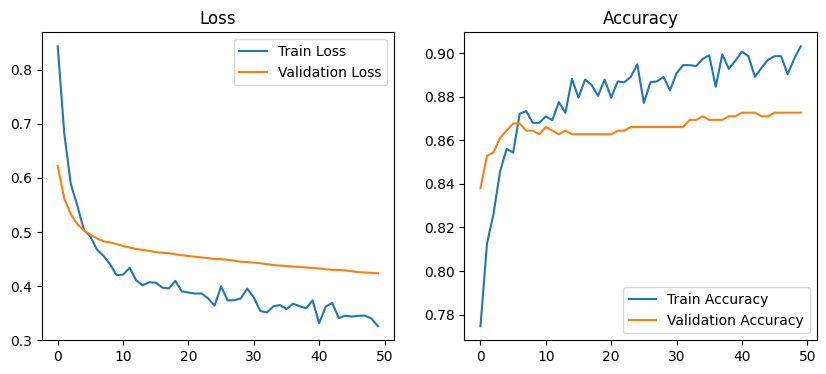

In [27]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

show_graphs(history)

In [32]:
ruta_nuevo_ecg = '/content/hd.jpeg'

# Llamamos a tu función para obtener el vector del nuevo ECG
# Asegurate de que tu función ecg_to_vector esté definida o importada
try:
    vector_nuevo_ecg = ecg_to_vector(ruta_nuevo_ecg, smooth=True) # Usa los mismos parámetros que en el entrenamiento
    vector_nuevo_ecg = resize_vector(vector_nuevo_ecg, target_len=4096)
    print(f"ECG procesado, longitud del vector: {len(vector_nuevo_ecg)}")
except Exception as e:
    print(f"Error al procesar el ECG: {e}")
    exit()

# --- PASO 3: Preparar el Vector para el model ---
# El model espera una entrada con forma (batch_size, longitud_vector, canales)
# Para una sola predicción, batch_size es 1.
vector_para_predecir = np.array([vector_nuevo_ecg]) # Poner el vector dentro de una lista para crear el batch
vector_para_predecir = vector_para_predecir.reshape(1, vector_para_predecir.shape[1], 1) # Añadir la dimensión del canal

print(f"Forma del vector para predicción: {vector_para_predecir.shape}")

# --- PASO 4: Realizar la Predicción ---
predicciones = model.predict(vector_para_predecir)

# `predicciones` es un array con las probabilidades para cada una de las 4 clases.
# Ejemplo: [[0.1, 0.7, 0.15, 0.05]]

# --- PASO 5: Obtener la Clase Predicha ---
# Encontramos el índice de la clase con la probabilidad más alta
clase_predicha_indice = np.argmax(predicciones[0])
probabilidad_maxima = np.max(predicciones[0])

print("-" * 30)
print(f"Predicción (probabilidades): {predicciones[0]}")
print(f"Índice de Clase Predicha: {clase_predicha_indice}")
print(f"Probabilidad de la clase predicha: {probabilidad_maxima * 100:.2f}%")
print("-" * 30)

# --- (Opcional) PASO 6: Mapear el Índice al Nombre de la Clase ---
# Si tenés un diccionario que mapea índices a nombres (como el 'class_map' que usamos antes):
# class_map = {
#0: 'ECG Images of Myocardial Infarction Patients (240x12=2880)'
#1: 'ECG Images of Patient that have History of MI (172x12=2064)'
#2: 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)'
#3: 'Normal Person ECG Images (284x12=3408)'} # Ejemplo
# nombre_clase_predicha = [nombre for nombre, indice in class_map.items() if indice == clase_predicha_indice][0]
# print(f"Nombre de la Clase Predicha: {nombre_clase_predicha}")

ECG procesado, longitud del vector: 4096
Forma del vector para predicción: (1, 4096, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
------------------------------
Predicción (probabilidades): [9.9998140e-01 1.1646878e-11 1.8617184e-05 2.8132585e-09]
Índice de Clase Predicha: 0
Probabilidad de la clase predicha: 100.00%
------------------------------


In [31]:
model.save("ecg_modelVectorDense3.h5")

In [ ]:
#!git push origin main